In [14]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [15]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Osama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
train_classification_df = pd.read_csv("/Users/Osama/Downloads/CS412PROJ/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [17]:
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [18]:
username2_category["kod8net"]

'tech'

In [19]:
train_data_path = "/Users/Osama/Downloads/CS412PROJ/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile

In [20]:
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.shape

(2741, 44)

In [21]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [22]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Osama\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji
from sklearn.feature_selection import SelectKBest, chi2

def preprocess_text(text: str):
    

    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)



custom_stopwords = list(set(turkish_stopwords).union({
    'the'
}))
vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=15000,min_df=10,sublinear_tf=True,smooth_idf=False,ngram_range=(1, 3))

# fit the vectorizer
vectorizer.fit(corpus)

# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]
feature_names = vectorizer.get_feature_names_out()


chi2_selector = SelectKBest(chi2, k=5000) 
x_post_train_selected = chi2_selector.fit_transform(x_post_train, y_train)

selected_feature_indices = chi2_selector.get_support(indices=True)
selected_feature_names = np.array(feature_names)[selected_feature_indices]



df_tfidf = pd.DataFrame(x_post_train_selected.toarray(), columns=selected_feature_names)

print(df_tfidf.sum().sort_values(ascending=False).head(30))


'''
# Inspect the frequency of each word
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)

# Show the most frequent words (words in many posts)
print(df_tfidf.sum().sort_values(ascending=False).head(30))

'''


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)




# Transform the test set using the same feature selection
x_post_test_selected = chi2_selector.transform(x_post_test)



the              43.234850
olarak           40.352663
kutlu            38.096409
kutlu olsun      37.759918
güzel            37.389047
and              34.504780
of               34.106894
to               33.099203
birlikte         32.901064
in               32.374707
with             28.743966
bilgi            28.325731
teşekkür         28.247761
mustafa          27.676218
for              27.280477
türkiye          27.194764
you              26.948208
kemal            26.702591
is               25.541688
mustafa kemal    25.536023
mi               25.390266
ziyaret          25.182333
olmak            24.740089
ben              24.492370
sonra            24.243549
hafta            24.095780
lezzet           23.966902
bekliyor         23.044388
bekliyoruz       22.340900
our              22.187366
dtype: float64


In [24]:
# Making sure everything is fine
assert y_train.count("NA") == 0


In [25]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['ab', 'abant', 'abd', ..., 'şıklığın', 'şımartın', 'şırnak'],
      dtype=object)

In [26]:
df_tfidf = pd.DataFrame(x_post_train_selected.toarray(), columns=selected_feature_names)
df_tfidf.head(2)

,abant,abdullah,abi,abiye,accessories,accommodation,accompanied,accompanied by,activities,acı,...,şubelerinde,şubemiz,şölen,şöleni,şükür,şık,şık bir,şıklık,şıklığı,şıklığın
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.04435,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


In [27]:
df_tfidf.shape

(2741, 5000)

In [28]:
print("Shape of df_tfidf:", df_tfidf.shape)
print("Length of y_train:", len(y_train))

Shape of df_tfidf: (2741, 5000)
Length of y_train: 2741


In [29]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train,random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2,random_state=42)

In [30]:
x_train.shape

(2192, 5000)

In [31]:
x_val.shape

(549, 5000)

In [32]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import numpy as np
from collections import Counter


class_counts = Counter(y_train)
total_samples = len(y_train)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
log_class_weights = {cls: 1 / (np.log(cnt) / np.log(20)) for cls, cnt in zip(unique_classes, class_counts)}
print("Class Weights with Log10 scaling:", log_class_weights)


# To compare with 'balanced' class weights
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}
print("Class Weights:", class_weight_dict)


from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix


svm_model = LinearSVC(class_weight=log_class_weights,max_iter=2000,random_state=123)
svm_model.fit(x_train, y_train)


Class Weights with Log10 scaling: {'art': 0.5955211694024377, 'entertainment': 0.5394838964231858, 'fashion': 0.5470194853204887, 'food': 0.4981500114024804, 'gaming': 1.301029995663981, 'health and lifestyle': 0.49958412562650956, 'mom and children': 0.6268371758695794, 'sports': 0.6657464410787219, 'tech': 0.532667665109185, 'travel': 0.5487105689237657}
Class Weights: {'art': 1.4326797385620915, 'entertainment': 0.8496124031007752, 'fashion': 0.9171548117154812, 'food': 0.5359413202933986, 'gaming': 21.92, 'health and lifestyle': 0.545273631840796, 'mom and children': 1.842016806722689, 'sports': 2.4355555555555557, 'tech': 0.7913357400722022, 'travel': 0.9327659574468085}


LinearSVC(class_weight={'art': 0.5955211694024377,
                        'entertainment': 0.5394838964231858,
                        'fashion': 0.5470194853204887,
                        'food': 0.4981500114024804, 'gaming': 1.301029995663981,
                        'health and lifestyle': 0.49958412562650956,
                        'mom and children': 0.6268371758695794,
                        'sports': 0.6657464410787219, 'tech': 0.532667665109185,
                        'travel': 0.5487105689237657},
          max_iter=2000, random_state=123)

In [33]:
'''from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svm_model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)'''


"from sklearn.model_selection import GridSearchCV\nparam_grid = {'svc__C': [1, 5, 10, 50],\n              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}\ngrid = GridSearchCV(svm_model, param_grid)\n\n%time grid.fit(Xtrain, ytrain)\nprint(grid.best_params_)"

In [34]:
#@title Train Data
y_train_pred = svm_model.predict(x_train)

print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred, zero_division=0))

Accuracy: 0.9552919708029197

Classification Report:
                      precision    recall  f1-score   support

                 art       0.98      0.90      0.94       153
       entertainment       0.96      0.92      0.94       258
             fashion       0.95      0.97      0.96       239
                food       0.97      0.99      0.98       409
              gaming       1.00      1.00      1.00        10
health and lifestyle       0.94      0.93      0.93       402
    mom and children       0.97      0.96      0.97       119
              sports       1.00      0.94      0.97        90
                tech       0.92      0.98      0.95       277
              travel       0.96      0.97      0.96       235

            accuracy                           0.96      2192
           macro avg       0.97      0.96      0.96      2192
        weighted avg       0.96      0.96      0.96      2192



In [35]:
y_val_pred = svm_model.predict(x_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

Accuracy: 0.7158469945355191

Classification Report:
                      precision    recall  f1-score   support

                 art       0.60      0.16      0.25        38
       entertainment       0.68      0.42      0.51        65
             fashion       0.64      0.77      0.70        60
                food       0.83      0.94      0.88       102
              gaming       0.00      0.00      0.00         3
health and lifestyle       0.67      0.78      0.72       100
    mom and children       0.70      0.53      0.60        30
              sports       0.78      0.78      0.78        23
                tech       0.72      0.91      0.80        69
              travel       0.70      0.73      0.72        59

            accuracy                           0.72       549
           macro avg       0.63      0.60      0.60       549
        weighted avg       0.70      0.72      0.69       549

Confusion Matrix:
 [[ 6  4 11  3  0  6  1  1  4  2]
 [ 2 27  5  5  0 12  1  

In [36]:
# Micro-checking misclassified instances to understand possible reasons better

val_usernames = train_usernames[len(x_train):] 
val_corpus = corpus[len(x_train):]

y_val_aligned = y_val[:len(val_usernames)]
y_val_pred_aligned = y_val_pred[:len(val_usernames)]

val_data = pd.DataFrame({
    "Username": val_usernames,
    "True Label": y_val_aligned,
    "Predicted Label": y_val_pred_aligned,
    "Captions": val_corpus
})


misclassified = val_data[val_data["True Label"] != val_data["Predicted Label"]]


print("Misclassified Samples with Captions:")
for _, row in misclassified.iterrows():
    print(f"Username: {row['Username']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print(f"Captions: {row['Captions']}\n")


Misclassified Samples with Captions:
Username: zekiinal09
True Label: art
Predicted Label: entertainment
Captions: bugün cabi muhtarım tayfun karaoğlan geyre muhtarım nevcet çoban tekeliler muhtarım serkan anil çamarasi muhtarım yusuf sevim yolalti muhtarım ali kocaağoğlu dikmen muhtarım hüseyin çeker yaykin muhtarım osman ali aktan ve güzelbeyli muhtarım celal ingay ile yaklaşan yerel seçimler ile ilgili sohbet ettik hoş sohbetlerinden dolayı kendilerine teşekkür ediyorum
birine çamur atmadan önce düşün ve sakin unutma ilk önce senin ellerin kirlenecek sağlikli mutlu bereketli bir hafta dileğiyle hayirli haftalar diliyorum
ilçemiz palamutçuk mahallesi şöför esnaflarımızdan ahmet kaya kardeşimizin oğlunun asker yemeğine katıldık allah kabul etsin sağ salim gidip gelmeyi nasip etsin inşaallah
bugün ilçemiz esnaf kefalet odası başkanı recep karataşziraat odası başkanı ibrahim iren şöförler odası başkanı mustafa gülgen ve iyi parti kadın kolları başkanı nihal deliktaşı ziyaret ettimkendil

In [ ]:
#@title Test Data
test_data_path = "/Users/Osama/Downloads/CS412PROJ/test-classification-round1.dat"

with open(test_data_path, "rt") as fh:
    for i, line in enumerate(fh):
        print(line.strip())
        if i >= 4:  # Stop after 5 lines
            break

print("*****")

test_unames = []
with open(test_data_path, "rt") as fh:
  for line in fh:
    test_unames.append(line.strip())

print(test_unames[:5])

In [ ]:
x_test = []

for uname in test_unames:
  try:
    index = test_usernames.index(uname)
    x_test.append(x_post_test[index].toarray()[0])
  except Exception as e:
    try:
      index = train_usernames.index(uname)
      x_test.append(x_post_train[index].toarray()[0])
    except Exception as e:
      print(uname)


test_unames.remove("screenname")

In [ ]:
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
df_test.head(2)

In [ ]:
test_pred = svm_model.predict(df_test)

output = dict()
for index, uname in enumerate(test_unames):
  output[uname] = test_pred[index]

with open("prediction-classification-round3.json", "w") as of:
  json.dump(output, of, indent=4)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

y_pred = svm_model.predict(x_val)

# Generate classification report
report = classification_report(y_val, y_pred, output_dict=True)

# Convert to a Pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Display as a table
print("Classification Report:")
print(report_df)




Classification Report:
                      precision    recall  f1-score     support
art                    0.600000  0.157895  0.250000   38.000000
entertainment          0.675000  0.415385  0.514286   65.000000
fashion                0.638889  0.766667  0.696970   60.000000
food                   0.827586  0.941176  0.880734  102.000000
gaming                 0.000000  0.000000  0.000000    3.000000
health and lifestyle   0.672414  0.780000  0.722222  100.000000
mom and children       0.695652  0.533333  0.603774   30.000000
sports                 0.782609  0.782609  0.782609   23.000000
tech                   0.715909  0.913043  0.802548   69.000000
travel                 0.704918  0.728814  0.716667   59.000000
accuracy               0.715847  0.715847  0.715847    0.715847
macro avg              0.631298  0.601892  0.596981  549.000000
weighted avg           0.704045  0.715847  0.693217  549.000000


C:\Users\Osama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Osama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Osama\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

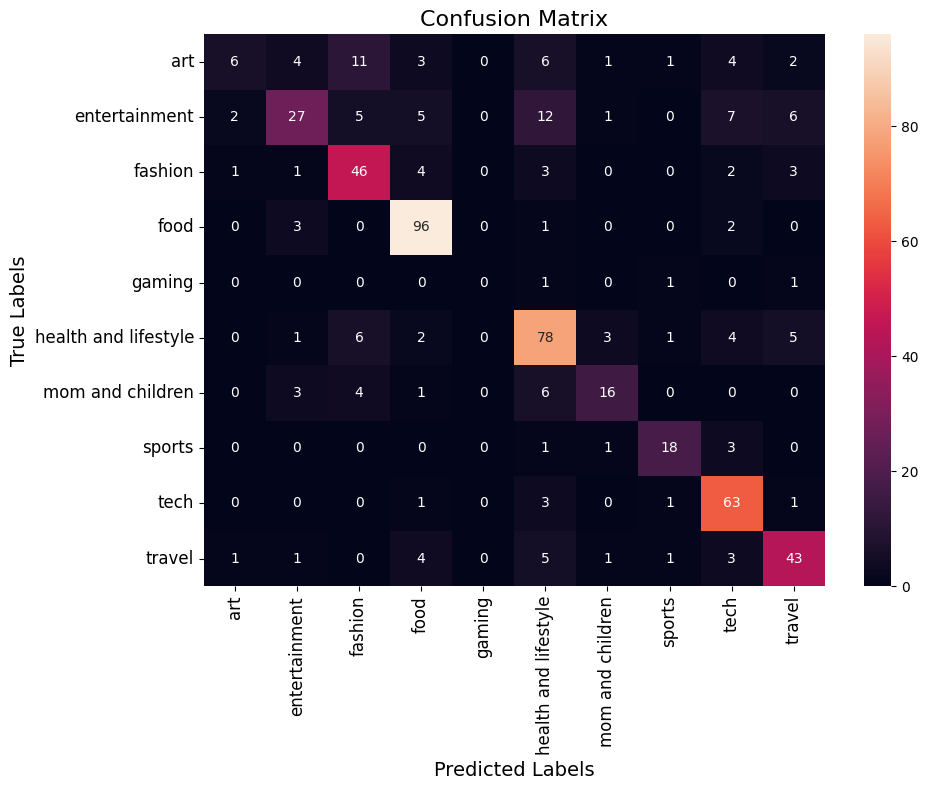

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))  # Increased size for better fitting
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Ensure everything fits well
plt.show()



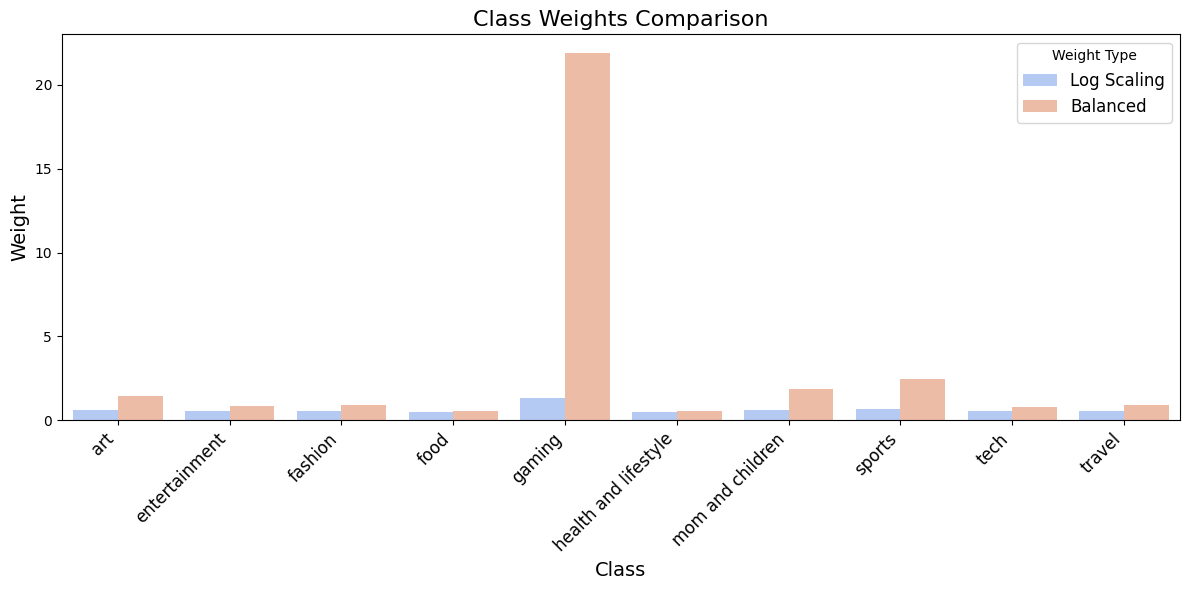

In [56]:
# Plot the class weights
plt.figure(figsize=(12, 6))  # Increased width for better fit
sns.barplot(data=weights_melted, x="Class", y="Weight", hue="Weight Type", palette="coolwarm")
plt.title("Class Weights Comparison", fontsize=16)
plt.ylabel("Weight", fontsize=14)
plt.xlabel("Class", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better fit
plt.legend(title="Weight Type", fontsize=12)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


C:\Users\Osama\AppData\Local\Temp\ipykernel_22224\1870919402.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


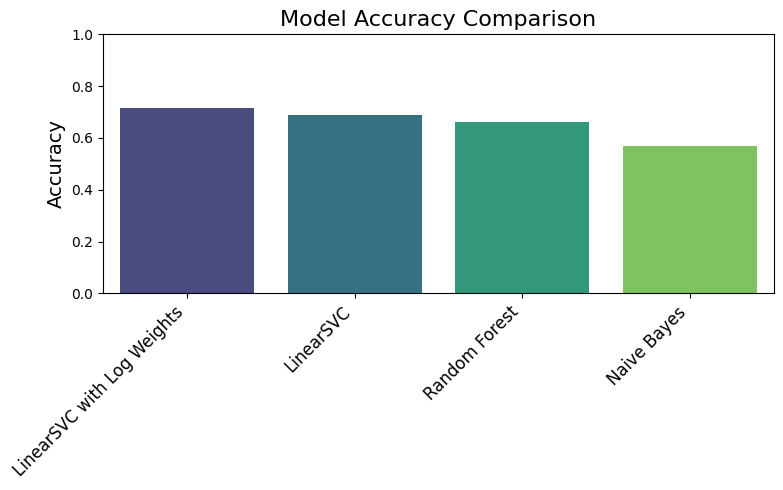

In [58]:
# Accuracy Plot
model_names = ["LinearSVC with Log Weights", "LinearSVC","Random Forest","Naive Bayes"]
accuracies = [accuracy, 0.69, 0.66, 0.57]  # Add other model accuracies here

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate labels for better fit
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [64]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Example: y_test = true labels, y_prob = predicted probabilities
precision, recall, _ = precision_recall_curve(y_val, y_pred)

plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


ValueError: multiclass format is not supported